In [245]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 1. FAOSTAT Crop Yield Data
# ------------------------

In [246]:
# Load the datasets
faostat_df = pd.read_csv("1_FAOSTAT_data_en_5-13-2025.csv")

In [247]:
# Inspect the dataset
print("FAOSTAT Initial Info:")
print(faostat_df.info())
print(faostat_df.head())

FAOSTAT Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5292 entries, 0 to 5291
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       5292 non-null   object 
 1   Domain            5292 non-null   object 
 2   Area Code (M49)   5292 non-null   int64  
 3   Area              5292 non-null   object 
 4   Element Code      5292 non-null   int64  
 5   Element           5292 non-null   object 
 6   Item Code (CPC)   5292 non-null   float64
 7   Item              5292 non-null   object 
 8   Year Code         5292 non-null   int64  
 9   Year              5292 non-null   int64  
 10  Unit              5292 non-null   object 
 11  Value             5142 non-null   float64
 12  Flag              5292 non-null   object 
 13  Flag Description  5292 non-null   object 
 14  Note              102 non-null    object 
dtypes: float64(2), int64(4), object(9)
memory usage: 620.3+ KB
None
  D

In [248]:
# Select relevant columns (assuming Area, Item, Element, Year, Unit, Value are key)
faostat_df = faostat_df[['Area', 'Item', 'Element', 'Year', 'Unit', 'Value']]

In [249]:
# Filter for Ethiopia and relevant elements (Yield, Area harvested, Production)
faostat_df = faostat_df[faostat_df['Area'] == 'Ethiopia']
elements = ['Yield', 'Area harvested', 'Production']
faostat_df = faostat_df[faostat_df['Element'].isin(elements)]

In [250]:
# Check for missing values
print("FAOSTAT Missing Values:")
print(faostat_df.isnull().sum())

FAOSTAT Missing Values:
Area         0
Item         0
Element      0
Year         0
Unit         0
Value      150
dtype: int64


In [251]:
# Drop rows with missing values in 'Value' (if any)
faostat_df = faostat_df.dropna(subset=['Value'])

In [252]:
# Pivot the data to have Yield, Area harvested, and Production as columns
faostat_pivoted = faostat_df.pivot_table(
    index=['Area', 'Item', 'Year'],
    columns='Element',
    values='Value',
    aggfunc='first'
).reset_index()

In [253]:
# Rename columns for clarity
faostat_pivoted.columns = ['Area', 'Crop', 'Year', 'Area_Harvested', 'Production', 'Yield']

In [254]:
# Verify units (Yield: hg/ha, Area: ha, Production: tonnes)
print("FAOSTAT Units:")
print(faostat_df[['Element', 'Unit']].drop_duplicates())

FAOSTAT Units:
          Element   Unit
0  Area harvested     ha
1           Yield  kg/ha
2      Production      t


In [255]:
# Save cleaned FAOSTAT dataset
# faostat_pivoted.to_csv("Cleaned_FAOSTAT.csv", index=False)
print("FAOSTAT Cleaned Dataset Saved as 'Cleaned_FAOSTAT.csv'")

FAOSTAT Cleaned Dataset Saved as 'Cleaned_FAOSTAT.csv'


# ------------------------
# 2. NDVI Data
# ------------------------

In [256]:
# Load the datasets
ndvi_df = pd.read_csv("2_Ethiopia_NDVI_Monthly.csv")

In [257]:
# Inspect the dataset
print("NDVI Initial Info:")
print(ndvi_df.info())
print(ndvi_df.head())

NDVI Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  277 non-null    int64  
 1   NDVI          277 non-null    float64
 2   date          277 non-null    object 
 3   .geo          277 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 8.8+ KB
None
   system:index      NDVI     date                                    .geo
0             0  0.263435  2000-02  {"type":"MultiPoint","coordinates":[]}
1             1  0.258993  2000-03  {"type":"MultiPoint","coordinates":[]}
2             2  0.312295  2000-04  {"type":"MultiPoint","coordinates":[]}
3             3  0.437923  2000-05  {"type":"MultiPoint","coordinates":[]}
4             4  0.399441  2000-06  {"type":"MultiPoint","coordinates":[]}


In [258]:
# Drop irrelevant '.geo' column
ndvi_df = ndvi_df.drop(columns=['.geo', 'system:index'])

In [259]:
# Convert 'date' to datetime
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], format='%Y-%m')

In [260]:
# Validate NDVI values (should be between -1 and 1)
invalid_ndvi = ndvi_df[(ndvi_df['NDVI'] < -1) | (ndvi_df['NDVI'] > 1)]
if not invalid_ndvi.empty:
    print("Invalid NDVI values found:", invalid_ndvi)
else:
    print("All NDVI values are within valid range (-1 to 1).")

All NDVI values are within valid range (-1 to 1).


In [261]:
# Check for missing values
print("NDVI Missing Values:")
print(ndvi_df.isnull().sum())

NDVI Missing Values:
NDVI    0
date    0
dtype: int64


In [262]:
# Drop rows with missing NDVI values (if any)
ndvi_df = ndvi_df.dropna(subset=['NDVI'])

In [263]:
# Extract year and month for potential aggregation
ndvi_df['Year'] = ndvi_df['date'].dt.year
ndvi_df['Month'] = ndvi_df['date'].dt.month

# Aggregate NDVI to yearly averages (or seasonal, depending on crop cycles)
# For now, we'll compute yearly averages; adjust for seasonal if needed
ndvi_yearly = ndvi_df.groupby('Year')['NDVI'].mean().reset_index()

In [264]:
# Save cleaned NDVI dataset
# ndvi_yearly.to_csv("Cleaned_NDVI.csv", index=False)
print("NDVI Cleaned Dataset Saved as 'Cleaned_NDVI.csv'")

NDVI Cleaned Dataset Saved as 'Cleaned_NDVI.csv'


In [265]:
# Preview cleaned datasets
print("\nCleaned FAOSTAT Preview:")
print(faostat_pivoted.head())
print("\nCleaned NDVI Preview:")
print(ndvi_yearly.head())


Cleaned FAOSTAT Preview:
       Area                                               Crop  Year  \
0  Ethiopia  Anise, badian, coriander, cumin, caraway, fenn...  2000   
1  Ethiopia  Anise, badian, coriander, cumin, caraway, fenn...  2001   
2  Ethiopia  Anise, badian, coriander, cumin, caraway, fenn...  2002   
3  Ethiopia  Anise, badian, coriander, cumin, caraway, fenn...  2003   
4  Ethiopia  Anise, badian, coriander, cumin, caraway, fenn...  2004   

   Area_Harvested  Production  Yield  
0           800.0       500.0  625.0  
1           960.0       600.0  625.0  
2          1120.0       700.0  625.0  
3          1280.0       800.0  625.0  
4          1440.0       900.0  625.0  

Cleaned NDVI Preview:
   Year      NDVI
0  2000  0.400037
1  2001  0.401398
2  2002  0.400534
3  2003  0.405961
4  2004  0.405473


# ------------------------
# 3. NASA POWER Weather Data
# ------------------------

# ------------------------
### 3.1 Solar Radiation
# ------------------------

In [266]:
# Load the dataset
nasa_df = pd.read_csv('3_POWER_Regional_Monthly_2000_2023 (2).csv', skiprows=9)

In [267]:
# Inspect the dataset
print("NASA Power Initial Info:")
print(nasa_df.info())
print(nasa_df.head())

NASA Power Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PARAMETER  2160 non-null   object 
 1   YEAR       2160 non-null   int64  
 2   LAT        2160 non-null   float64
 3   LON        2160 non-null   float64
 4   JAN        2160 non-null   float64
 5   FEB        2160 non-null   float64
 6   MAR        2160 non-null   float64
 7   APR        2160 non-null   float64
 8   MAY        2160 non-null   float64
 9   JUN        2160 non-null   float64
 10  JUL        2160 non-null   float64
 11  AUG        2160 non-null   float64
 12  SEP        2160 non-null   float64
 13  OCT        2160 non-null   float64
 14  NOV        2160 non-null   float64
 15  DEC        2160 non-null   float64
 16  ANN        2160 non-null   float64
dtypes: float64(15), int64(1), object(1)
memory usage: 287.0+ KB
None
           PARAMETER  YEAR   LAT   LON

In [268]:
# Check if PARAMETER is uniform (all ALLSKY_SFC_SW_DWN)
if nasa_df['PARAMETER'].nunique() == 1:
    nasa_df = nasa_df.drop(columns=['PARAMETER'])

In [269]:
# Replace -999 with NaN for missing data
nasa_df = nasa_df.replace(-999, np.nan)

In [270]:
# Check for missing values
print("NASA Power Missing Values:")
print(nasa_df.isnull().sum())

NASA Power Missing Values:
YEAR    0
LAT     0
LON     0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
JUL     0
AUG     0
SEP     0
OCT     0
NOV     0
DEC     0
ANN     0
dtype: int64


In [271]:
# Drop rows with NaN in all monthly columns (JAN-DEC)
monthly_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
nasa_df = nasa_df.dropna(subset=monthly_cols, how='all')

# Melt monthly columns into long format
nasa_melted = pd.melt(
    nasa_df,
    id_vars=['YEAR', 'LAT', 'LON'],
    value_vars=monthly_cols,
    var_name='Month',
    value_name='Solar_Radiation'
)

# Map month abbreviations to numbers
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
nasa_melted['Month'] = nasa_melted['Month'].map(month_map)

In [272]:
# Create a datetime column
nasa_melted['Date'] = pd.to_datetime(nasa_melted[['YEAR', 'Month']].assign(DAY=1))

In [273]:
# Drop rows with NaN in Solar_Radiation
nasa_melted = nasa_melted.dropna(subset=['Solar_Radiation'])

In [274]:
# Aggregate spatially (average across LAT/LON) for national-level data
nasa_agg = nasa_melted.groupby(['Date', 'YEAR'])['Solar_Radiation'].mean().reset_index()

# Compute yearly averages for alignment with FAOSTAT
nasa_yearly = nasa_agg.groupby('YEAR')['Solar_Radiation'].mean().reset_index()

In [275]:
# Save cleaned datasets
# nasa_melted.to_csv("Cleaned_NASA_Power_SolarRadiation_monthly.csv", index=False)
# nasa_yearly.to_csv("Cleaned_NASA_Power_SolarRadiation_cleaned_yearly.csv", index=False)
print("NASA Power Cleaned Datasets Saved as 'Cleaned_NASA_Power_SolarRadiation_monthly.csv' and 'Cleaned_NASA_Power_SolarRadiation_cleaned_yearly.csv'")

# Preview cleaned datasets
print("\nCleaned NASA Power Monthly Preview:")
print(nasa_melted.head())
print("\nCleaned NASA Power Yearly Preview:")
print(nasa_yearly.head())

NASA Power Cleaned Datasets Saved as 'Cleaned_NASA_Power_SolarRadiation_monthly.csv' and 'Cleaned_NASA_Power_SolarRadiation_cleaned_yearly.csv'

Cleaned NASA Power Monthly Preview:
   YEAR   LAT   LON  Month  Solar_Radiation       Date
0  2000  10.5  33.5      1            21.93 2000-01-01
1  2000  10.5  34.5      1            21.52 2000-01-01
2  2000  10.5  35.5      1            21.68 2000-01-01
3  2000  10.5  36.5      1            21.49 2000-01-01
4  2000  10.5  37.5      1            22.38 2000-01-01

Cleaned NASA Power Yearly Preview:
   YEAR  Solar_Radiation
0  2000        21.225880
1  2001        20.336213
2  2002        20.732056
3  2003        21.020926
4  2004        21.042417


# ------------------------
### 3.2 Temperature
# ------------------------

In [276]:
# Load the dataset
nasa_temp_df = pd.read_csv('3_POWER_Regional_Monthly_2000_2023.csv', skiprows=9)

In [277]:
# Inspect the dataset
print("NASA Power Temperature Initial Info:")
print(nasa_temp_df.info())
print(nasa_temp_df.head())

NASA Power Temperature Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7296 entries, 0 to 7295
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PARAMETER  7296 non-null   object 
 1   YEAR       7296 non-null   int64  
 2   LAT        7296 non-null   float64
 3   LON        7296 non-null   float64
 4   JAN        7296 non-null   float64
 5   FEB        7296 non-null   float64
 6   MAR        7296 non-null   float64
 7   APR        7296 non-null   float64
 8   MAY        7296 non-null   float64
 9   JUN        7296 non-null   float64
 10  JUL        7296 non-null   float64
 11  AUG        7296 non-null   float64
 12  SEP        7296 non-null   float64
 13  OCT        7296 non-null   float64
 14  NOV        7296 non-null   float64
 15  DEC        7296 non-null   float64
 16  ANN        7296 non-null   float64
dtypes: float64(15), int64(1), object(1)
memory usage: 969.1+ KB
None
  PARAMETER  YEAR   LAT   

In [278]:
# Check if PARAMETER is uniform (all T2M)
if nasa_temp_df['PARAMETER'].nunique() == 1:
    nasa_temp_df = nasa_temp_df.drop(columns=['PARAMETER'])

# Replace -999 with NaN for missing data
nasa_temp_df = nasa_temp_df.replace(-999, np.nan)

# Check for missing values
print("NASA Power Temperature Missing Values:")
print(nasa_temp_df.isnull().sum())

NASA Power Temperature Missing Values:
YEAR    0
LAT     0
LON     0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
JUL     0
AUG     0
SEP     0
OCT     0
NOV     0
DEC     0
ANN     0
dtype: int64


In [279]:
# Drop rows with NaN in all monthly columns (JAN-DEC)
monthly_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
nasa_temp_df = nasa_temp_df.dropna(subset=monthly_cols, how='all')

In [280]:
# Melt monthly columns into long format
nasa_temp_melted = pd.melt(
    nasa_temp_df,
    id_vars=['YEAR', 'LAT', 'LON'],
    value_vars=monthly_cols,
    var_name='Month',
    value_name='Temperature'
)

# Map month abbreviations to numbers
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
nasa_temp_melted['Month'] = nasa_temp_melted['Month'].map(month_map)

In [281]:
# Create a datetime column
nasa_temp_melted['Date'] = pd.to_datetime(nasa_temp_melted[['YEAR', 'Month']].assign(DAY=1))

In [282]:
# Drop rows with NaN in Temperature
nasa_temp_melted = nasa_temp_melted.dropna(subset=['Temperature'])

In [283]:
# Aggregate spatially (average across LAT/LON) for national-level data
nasa_temp_agg = nasa_temp_melted.groupby(['Date', 'YEAR'])['Temperature'].mean().reset_index()

In [284]:
# Compute yearly averages for alignment with FAOSTAT
nasa_temp_yearly = nasa_temp_agg.groupby('YEAR')['Temperature'].mean().reset_index()

In [285]:
# Save cleaned datasets
# nasa_temp_melted.to_csv("Cleaned_NASA_Power_Temperature_monthly.csv", index=False)
# nasa_temp_yearly.to_csv("Cleaned_NASA_Power_Temperature_yearly.csv", index=False)
print("Cleaned Datasets 'Cleaned_NASA_Power_Temperature_monthly.csv' and 'Cleaned_NASA_Power_Temperature_yearly.csv'")

# Preview cleaned datasets
print("\nCleaned NASA Power Temperature Monthly Preview:")
print(nasa_temp_melted.head())
print("\nCleaned NASA Power Temperature Yearly Preview:")
print(nasa_temp_yearly.head())

Cleaned Datasets 'Cleaned_NASA_Power_Temperature_monthly.csv' and 'Cleaned_NASA_Power_Temperature_yearly.csv'

Cleaned NASA Power Temperature Monthly Preview:
   YEAR   LAT     LON  Month  Temperature       Date
0  2000  10.0  33.125      1        29.43 2000-01-01
1  2000  10.0  33.750      1        29.71 2000-01-01
2  2000  10.0  34.375      1        25.70 2000-01-01
3  2000  10.0  35.000      1        23.26 2000-01-01
4  2000  10.0  35.625      1        25.55 2000-01-01

Cleaned NASA Power Temperature Yearly Preview:
   YEAR  Temperature
0  2000    24.219794
1  2001    24.240258
2  2002    24.669570
3  2003    24.660510
4  2004    24.621598


# ------------------------
### 3.3 Precipitation
# ------------------------

In [286]:
# Load the dataset
nasa_precip_df = pd.read_csv('3_POWER_Regional_Monthly_2000_2023 (1).csv', skiprows=9)

In [287]:
# Inspect the dataset
print("NASA Power Precipitation Initial Info:")
print(nasa_precip_df.info())
print(nasa_precip_df.head())

NASA Power Precipitation Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7296 entries, 0 to 7295
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PARAMETER  7296 non-null   object 
 1   YEAR       7296 non-null   int64  
 2   LAT        7296 non-null   float64
 3   LON        7296 non-null   float64
 4   JAN        7296 non-null   float64
 5   FEB        7296 non-null   float64
 6   MAR        7296 non-null   float64
 7   APR        7296 non-null   float64
 8   MAY        7296 non-null   float64
 9   JUN        7296 non-null   float64
 10  JUL        7296 non-null   float64
 11  AUG        7296 non-null   float64
 12  SEP        7296 non-null   float64
 13  OCT        7296 non-null   float64
 14  NOV        7296 non-null   float64
 15  DEC        7296 non-null   float64
 16  ANN        7296 non-null   float64
dtypes: float64(15), int64(1), object(1)
memory usage: 969.1+ KB
None
     PARAMETER  YEAR   L

In [288]:
# Check if PARAMETER is uniform (all PRECTOTCORR)
if nasa_precip_df['PARAMETER'].nunique() == 1:
    nasa_precip_df = nasa_precip_df.drop(columns=['PARAMETER'])

In [289]:
# Replace -999 with NaN for missing data
nasa_precip_df = nasa_precip_df.replace(-999, np.nan)

# Check for missing values
print("NASA Power Precipitation Missing Values:")
print(nasa_precip_df.isnull().sum())

NASA Power Precipitation Missing Values:
YEAR    0
LAT     0
LON     0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
JUL     0
AUG     0
SEP     0
OCT     0
NOV     0
DEC     0
ANN     0
dtype: int64


In [290]:
# Drop rows with NaN in all monthly columns (JAN-DEC)
monthly_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
nasa_precip_df = nasa_precip_df.dropna(subset=monthly_cols, how='all')

In [291]:
# Melt monthly columns into long format
nasa_precip_melted = pd.melt(
    nasa_precip_df,
    id_vars=['YEAR', 'LAT', 'LON'],
    value_vars=monthly_cols,
    var_name='Month',
    value_name='Precipitation'
)

# Map month abbreviations to numbers
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
nasa_precip_melted['Month'] = nasa_precip_melted['Month'].map(month_map)

In [292]:
# Create a datetime column
nasa_precip_melted['Date'] = pd.to_datetime(nasa_precip_melted[['YEAR', 'Month']].assign(DAY=1))

In [293]:
# Drop rows with NaN in Precipitation
nasa_precip_melted = nasa_precip_melted.dropna(subset=['Precipitation'])

In [294]:
# Aggregate spatially (average across LAT/LON) for national-level data
nasa_precip_agg = nasa_precip_melted.groupby(['Date', 'YEAR'])['Precipitation'].mean().reset_index()

# Compute yearly averages for alignment with FAOSTAT
nasa_precip_yearly = nasa_precip_agg.groupby('YEAR')['Precipitation'].mean().reset_index()

In [295]:
# Save cleaned datasets
# nasa_precip_melted.to_csv("Cleaned_NASA_Power_Precipitation_monthly.csv", index=False)
# nasa_precip_yearly.to_csv("Cleaned_NASA_Power_Precipitation_yearly.csv", index=False)
print("NASA Power Precipitation Cleaned Datasets Saved as 'Cleaned_NASA_Power_Precipitation_monthly.csv' and 'Cleaned_NASA_Power_Precipitation_yearly.csv'")

# Preview cleaned datasets
print("\nCleaned NASA Power Precipitation Monthly Preview:")
print(nasa_precip_melted.head())
print("\nCleaned NASA Power Precipitation Yearly Preview:")
print(nasa_precip_yearly.head())

NASA Power Precipitation Cleaned Datasets Saved as 'Cleaned_NASA_Power_Precipitation_monthly.csv' and 'Cleaned_NASA_Power_Precipitation_yearly.csv'

Cleaned NASA Power Precipitation Monthly Preview:
   YEAR   LAT     LON  Month  Precipitation       Date
0  2000  10.0  33.125      1           0.00 2000-01-01
1  2000  10.0  33.750      1           0.02 2000-01-01
2  2000  10.0  34.375      1           0.05 2000-01-01
3  2000  10.0  35.000      1           0.04 2000-01-01
4  2000  10.0  35.625      1           0.01 2000-01-01

Cleaned NASA Power Precipitation Yearly Preview:
   YEAR  Precipitation
0  2000       1.640576
1  2001       1.767802
2  2002       1.674238
3  2003       1.633662
4  2004       1.579301


# ------------------------
# 4. Soil Data Extraction
# ------------------------

In [296]:
# Example for one soil file (e.g., pH), extract raster value at one point
# Coordinates example: (longitude, latitude)
coords = [(38.7, 9.0)]  # Addis Ababa region

# Load the raster
with rasterio.open('5_out.tif') as src:
    for coord in coords:
        row, col = src.index(*coord)
        ph_value = src.read(1)[row, col]
        print(f"Extracted pH value at {coord}: {ph_value}")

Extracted pH value at (38.7, 9.0): 386


# -----

#  ====> MERGE

In [297]:
# Define the crops
crops = [
    "Avocados", "Bananas", "Barley", "Cabbages", "Cereals n.e.c.",
    "Coffee, green", "Maize (corn)", "Mangoes, guavas and mangosteens",
    "Oranges", "Other vegetables, fresh n.e.c.", "Peas, dry", "Peas, green", "Pineapples",
    "Potatoes", "Rice", "Seed cotton, unginned", "Sorghum", "Sugar cane",
    "Sunflower seed", "Tomatoes", "Wheat"
]

# Load cleaned datasets
faostat_df = pd.read_csv("Cleaned_FAOSTAT.csv")
ndvi_df = pd.read_csv("Cleaned_NDVI.csv")
solar_df = pd.read_csv("Cleaned_NASA_Power_SolarRadiation_cleaned_yearly.csv")
temp_df = pd.read_csv("Cleaned_NASA_Power_Temperature_yearly.csv")
precip_df = pd.read_csv("Cleaned_NASA_Power_Precipitation_yearly.csv")

# Filter FAOSTAT for specified crops
faostat_df = faostat_df[faostat_df['Crop'].isin(crops)]

In [298]:
# Rename columns for clarity
# faostat_df = faostat_df.rename(columns={'Year': 'Year', 'Value': 'Yield'})
# ndvi_df = ndvi_df.rename(columns={'year': 'Year', 'NDVI': 'NDVI'})
solar_df = solar_df.rename(columns={'YEAR': 'Year', 'Solar_Radiation': 'SolarRadiation'})
temp_df = temp_df.rename(columns={'YEAR': 'Year', 'Temperature': 'Temperature'})
precip_df = precip_df.rename(columns={'YEAR': 'Year', 'Precipitation': 'Precipitation'})

In [299]:
# Select relevant columns
faostat_df = faostat_df[['Year', 'Crop', 'Yield']]
ndvi_df = ndvi_df[['Year', 'NDVI']]
solar_df = solar_df[['Year', 'SolarRadiation']]
temp_df = temp_df[['Year', 'Temperature']]
precip_df = precip_df[['Year', 'Precipitation']]

In [300]:
# Merge datasets on Year
merged_df = pd.merge(faostat_df, ndvi_df, on='Year', how='left')
merged_df = pd.merge(merged_df, solar_df, on='Year', how='left')
merged_df = pd.merge(merged_df, temp_df, on='Year', how='left')
merged_df = pd.merge(merged_df, precip_df, on='Year', how='left')

In [301]:
# Check for missing data
print("Missing Values in Merged Dataset:")
print(merged_df.isnull().sum())

Missing Values in Merged Dataset:
Year              0
Crop              0
Yield             0
NDVI              0
SolarRadiation    0
Temperature       0
Precipitation     0
dtype: int64


In [302]:
# Handle missing data (impute with mean for NDVI, SolarRadiation, Temperature, Precipitation)
for col in ['NDVI', 'SolarRadiation', 'Temperature', 'Precipitation']:
    merged_df[col] = merged_df[col].fillna(merged_df[col].mean())

In [303]:
# Verify data
print("\nMerged Dataset Info:")
print(merged_df.info())
print("\nMerged Dataset Preview:")
print(merged_df.head())


Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            490 non-null    int64  
 1   Crop            490 non-null    object 
 2   Yield           490 non-null    float64
 3   NDVI            490 non-null    float64
 4   SolarRadiation  490 non-null    float64
 5   Temperature     490 non-null    float64
 6   Precipitation   490 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 26.9+ KB
None

Merged Dataset Preview:
   Year      Crop   Yield      NDVI  SolarRadiation  Temperature  \
0  2000  Avocados  8000.0  0.400037       21.225880    24.219794   
1  2001  Avocados  5753.1  0.401398       20.336213    24.240258   
2  2002  Avocados  5769.2  0.400534       20.732056    24.669570   
3  2003  Avocados  5854.7  0.405961       21.020926    24.660510   
4  2004  Avocados  5153.9  0.405473 

In [304]:
# Save merged dataset
# merged_df.to_csv("Merged_CropYield_Environmental_yearly.csv", index=False)
print("Merged Dataset Saved as 'Merged_CropYield_Environmental_yearly.csv'")

Merged Dataset Saved as 'Merged_CropYield_Environmental_yearly.csv'


# -----

# ====> Explanatory Data Analysis

In [305]:
# Load merged dataset
df = pd.read_csv("Merged_CropYield_Environmental_yearly.csv")

# --- Summary Statistics ---
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
              Year          Yield        NDVI  SolarRadiation  Temperature  \
count   490.000000     490.000000  490.000000      490.000000   490.000000   
mean   2011.742857    7112.657143    0.406803       20.905362    24.076393   
std       6.866176   14175.076634    0.019321        0.290978     0.319447   
min    2000.000000     521.300000    0.337769       20.254352    23.548657   
25%    2006.000000    1576.750000    0.400252       20.725926    23.810452   
50%    2012.000000    2820.350000    0.405961       20.920963    24.006294   
75%    2018.000000    7280.100000    0.417158       21.046380    24.257423   
max    2023.000000  110416.700000    0.449618       21.474435    24.669570   

       Precipitation  
count     490.000000  
mean        2.499187  
std         0.626206  
min         1.579301  
25%         1.813122  
50%         2.576826  
75%         2.875167  
max         3.757163  


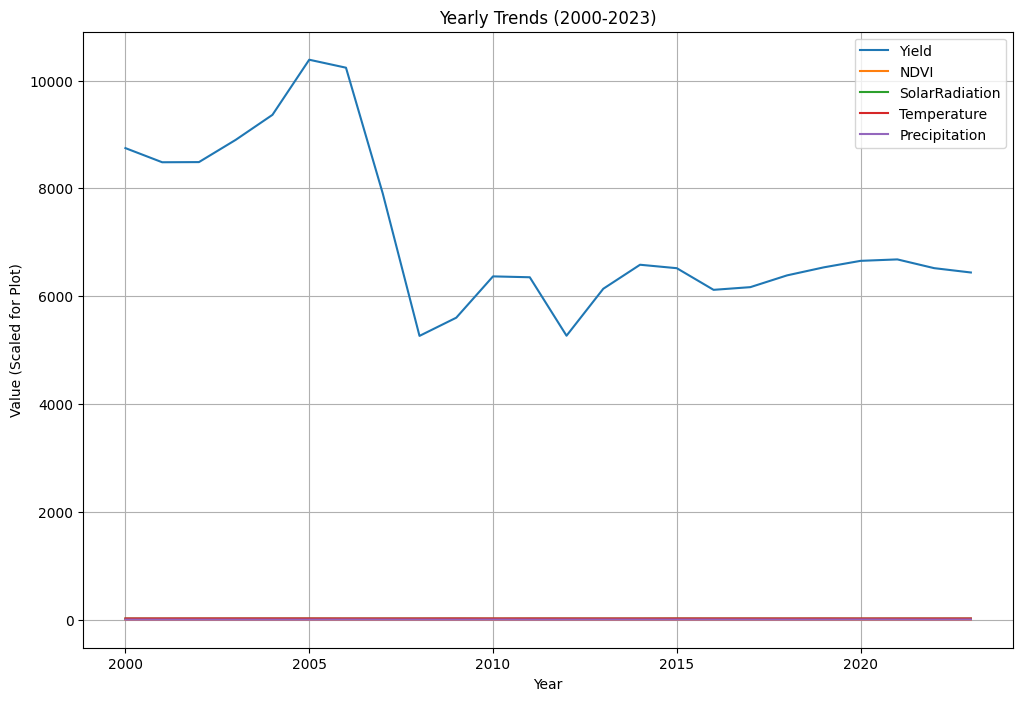

In [306]:
# --- Time Series Plots ---
plt.figure(figsize=(12, 8))
for col in ['Yield', 'NDVI', 'SolarRadiation', 'Temperature', 'Precipitation']:
    yearly_avg = df.groupby('Year')[col].mean()
    plt.plot(yearly_avg.index, yearly_avg, label=col)
plt.title('Yearly Trends (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Value (Scaled for Plot)')
plt.legend()
plt.grid(True)
# plt.savefig('z_time_series_trends.png')
plt.show()
plt.close()

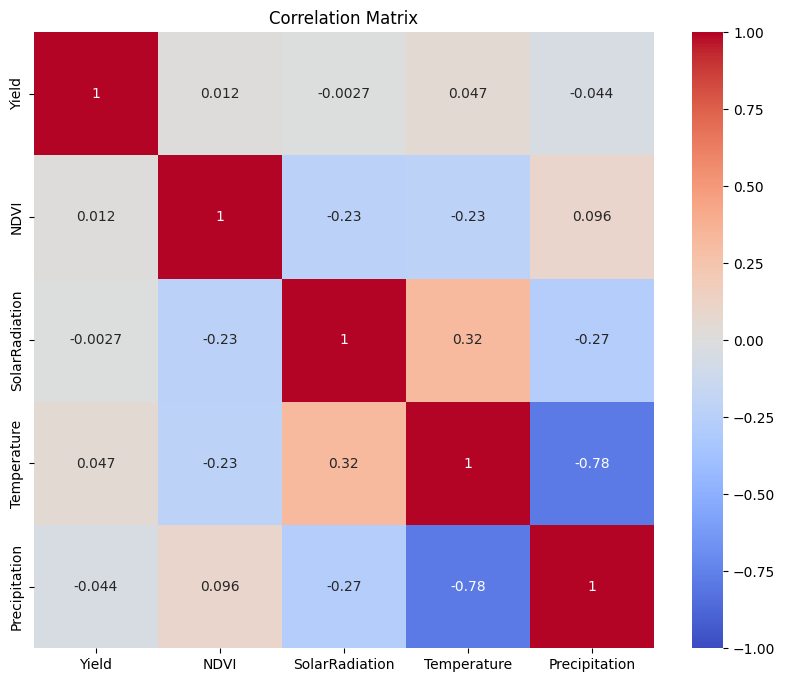

In [307]:
# --- Correlation Matrix ---
plt.figure(figsize=(10, 8))
corr = df[['Yield', 'NDVI', 'SolarRadiation', 'Temperature', 'Precipitation']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
# plt.savefig('z_correlation_matrix.png')
plt.show()
plt.close()

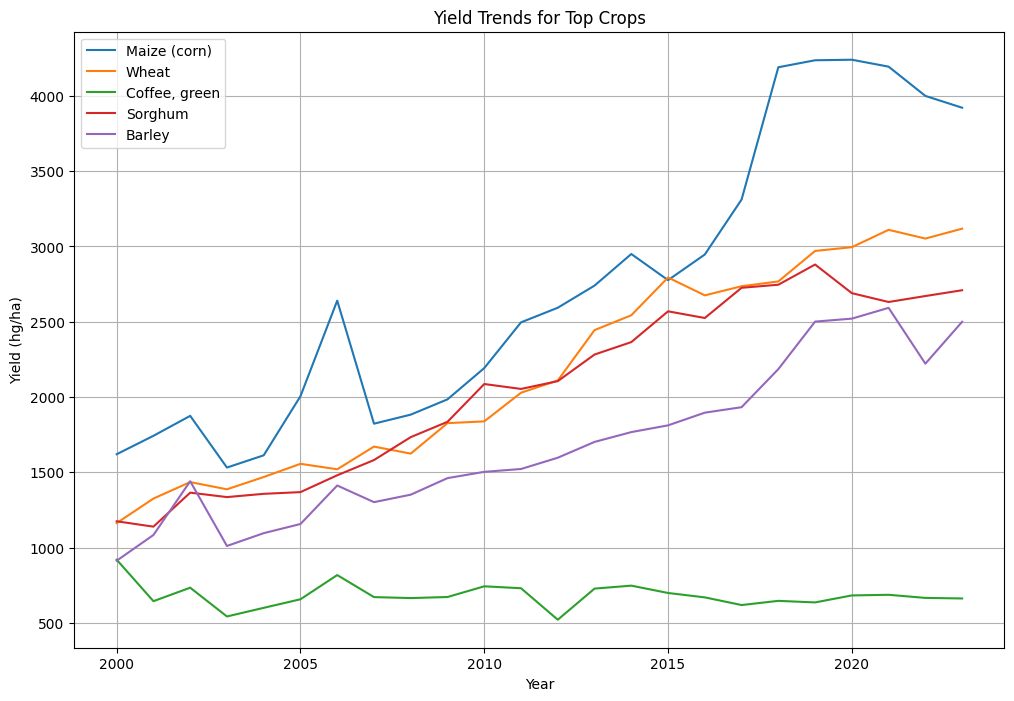

In [308]:
# --- Crop-Specific Yield Trends (Top 5 Crops) ---
top_crops = ['Maize (corn)', 'Wheat', 'Coffee, green', 'Sorghum', 'Barley']
plt.figure(figsize=(12, 8))
for crop in top_crops:
    crop_data = df[df['Crop'] == crop]
    plt.plot(crop_data['Year'], crop_data['Yield'], label=crop)
plt.title('Yield Trends for Top Crops')
plt.xlabel('Year')
plt.ylabel('Yield (hg/ha)')
plt.legend()
plt.grid(True)
# plt.savefig('z_crop_yield_trends.png')
plt.show()
plt.close()

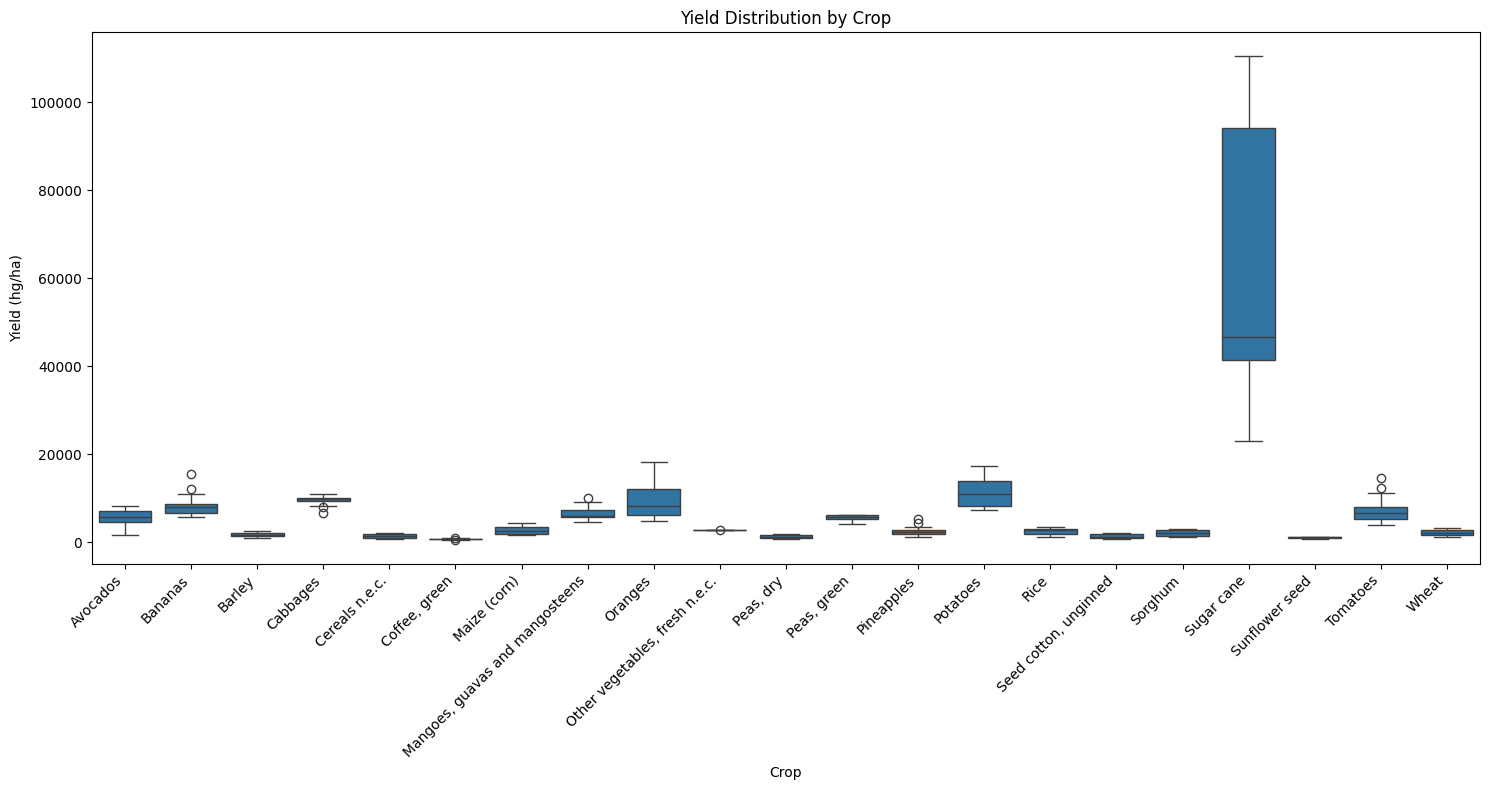

In [309]:
# --- Box Plot of Yields by Crop ---
plt.figure(figsize=(15, 8))
sns.boxplot(x='Crop', y='Yield', data=df)
plt.title('Yield Distribution by Crop')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Crop')
plt.ylabel('Yield (hg/ha)')
plt.tight_layout()
# plt.savefig('z_yield_boxplot.png')
plt.show()
plt.close()

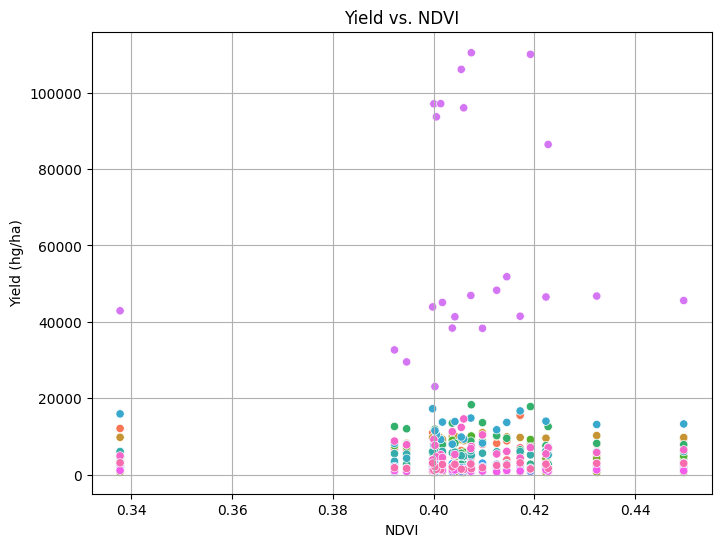

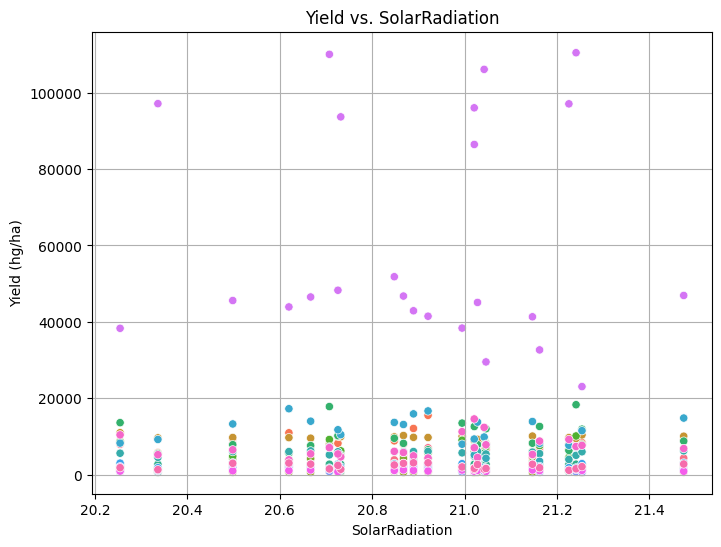

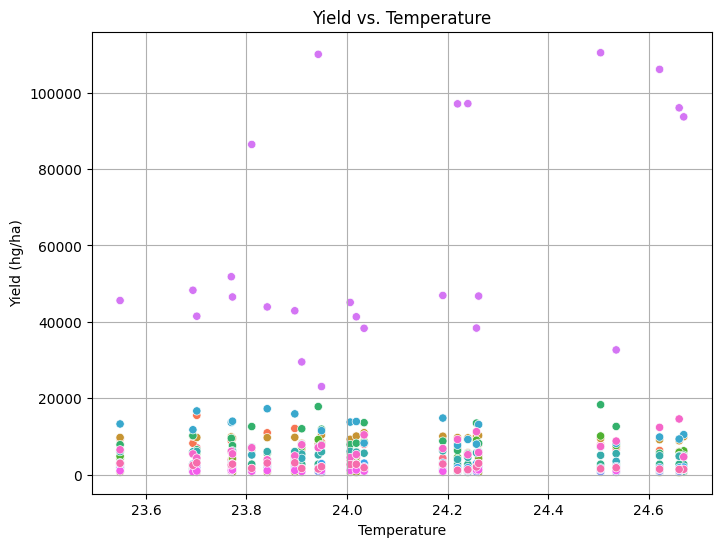

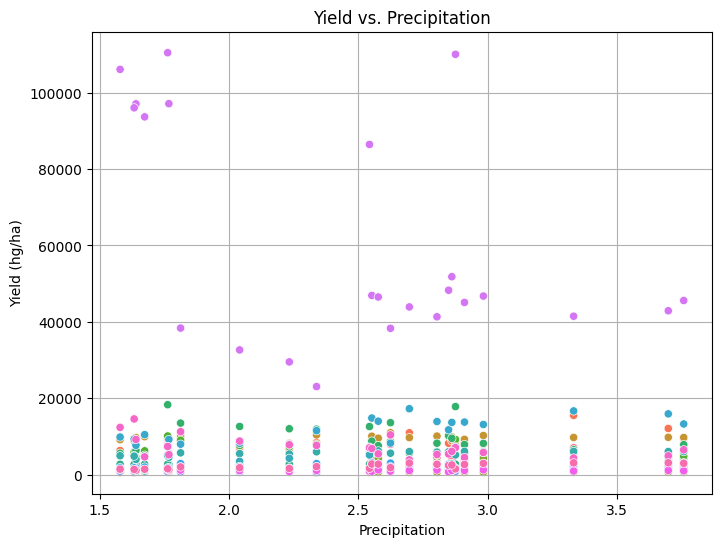

In [310]:
# --- Scatter Plots: Yield vs. Environmental Factors ---
for col in ['NDVI', 'SolarRadiation', 'Temperature', 'Precipitation']:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[col], y=df['Yield'], hue=df['Crop'], legend=False)
    plt.title(f'Yield vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Yield (hg/ha)')
    plt.grid(True)
    # plt.savefig(f'z_yield_vs_{col}.png')
    plt.show()
    plt.close()

# -----

# ===> FEATURE ENGINEERING

In [311]:
# Load the dataset
df = pd.read_csv("Merged_CropYield_Environmental_yearly.csv")

In [312]:
# 1. Temporal Features
# Create "Years Since 2000"
df['Years_Since_2000'] = df['Year'] - 2000

# Create "Decade" feature
df['Decade'] = (df['Year'] // 10 * 10).astype(str) + 's'

In [313]:
# 2. Categorical Encoding for Crop
# One-hot encode the Crop column
df = pd.get_dummies(df, columns=['Crop'], prefix='Crop')

In [314]:
# 3. Environmental Interactions
# Water Availability Index: Precipitation / Temperature
# Guard against division by zero
df['Water_Availability'] = df['Precipitation'] / df['Temperature'].replace(0, 1e-10)

# Vegetation-Solar Interaction: NDVI * SolarRadiation
df['NDVI_Solar_Interaction'] = df['NDVI'] * df['SolarRadiation']

In [315]:
# 4. Lag Features
# Sort by crop columns and year to ensure proper lagging
crop_columns = [col for col in df.columns if col.startswith('Crop_')]
df = df.sort_values(by=crop_columns + ['Year'])

# Previous Year's Yield
df['Prev_Year_Yield'] = df.groupby(crop_columns)['Yield'].shift(1)

# Previous Year's NDVI
df['Prev_Year_NDVI'] = df.groupby(crop_columns)['NDVI'].shift(1)

# Fill NaN values for lag features with the mean of the respective crop
df['Prev_Year_Yield'] = df.groupby(crop_columns)['Prev_Year_Yield'].fillna(df.groupby(crop_columns)['Yield'].transform('mean'))
df['Prev_Year_NDVI'] = df.groupby(crop_columns)['Prev_Year_NDVI'].fillna(df.groupby(crop_columns)['NDVI'].transform('mean'))

C:\Users\Natan\AppData\Local\Temp\ipykernel_2012\2352446070.py:13: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['Prev_Year_Yield'] = df.groupby(crop_columns)['Prev_Year_Yield'].fillna(df.groupby(crop_columns)['Yield'].transform('mean'))
C:\Users\Natan\AppData\Local\Temp\ipykernel_2012\2352446070.py:14: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['Prev_Year_NDVI'] = df.groupby(crop_columns)['Prev_Year_NDVI'].fillna(df.groupby(crop_columns)['NDVI'].transform('mean'))


In [316]:
# 5. Scaling/Normalization
# Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['NDVI', 'SolarRadiation', 'Temperature', 'Precipitation', 'Water_Availability', 'NDVI_Solar_Interaction', 'Prev_Year_Yield', 'Prev_Year_NDVI']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the first few rows of the transformed dataset
print(df.head())

# Save the transformed dataset for the next steps
# df.to_csv('Engineered_CropYield_Environmental_yearly.csv', index=False)


     Year   Yield      NDVI  SolarRadiation  Temperature  Precipitation  \
466  2000  1163.1  0.556714        0.796280     0.598742       0.028135   
467  2001  1325.9  0.568884        0.067095     0.616998       0.086553   
468  2002  1435.4  0.561158        0.391534     1.000000       0.043592   
469  2003  1387.4  0.609682        0.628296     0.991918       0.024961   
470  2004  1469.1  0.605317        0.645911     0.957203       0.000000   

     Years_Since_2000 Decade  Crop_Avocados  Crop_Bananas  ...  \
466                 0  2000s          False         False  ...   
467                 1  2000s          False         False  ...   
468                 2  2000s          False         False  ...   
469                 3  2000s          False         False  ...   
470                 4  2000s          False         False  ...   

     Crop_Seed cotton, unginned  Crop_Sorghum  Crop_Sugar cane  \
466                       False         False            False   
467                 

<Axes: >

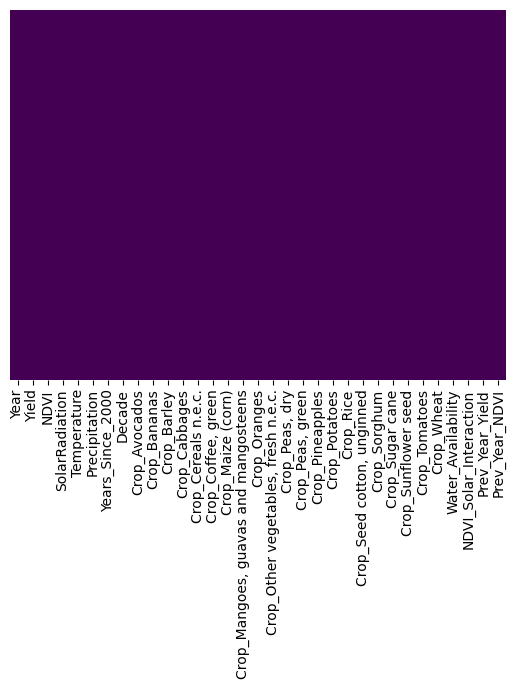

In [317]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# =======
# =======

# ------------------------
# PREDICTION MODEL
# ------------------------

In [318]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Train-Test Split

In [319]:
# Load the engineered dataset
df = pd.read_csv("Engineered_CropYield_Environmental_yearly.csv")


X = df.drop(columns=['Year', 'Yield', 'Decade'])
y = df['Yield']

In [320]:
# Train-test split: 2000-2019 for training, 2020-2023 for testing
train_mask = df['Year'] <= 2019
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

## Model Prediction

In [321]:
# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

#### Random Forest Regressor

In [322]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### XGBoost

In [323]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

#### Support vector machine

In [324]:
svr_model.fit(X_train, y_train)

SVR()

In [325]:
# Predict on test set
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test)

## Model Evaluation

In [326]:
# Evaluate models
models = {'Random Forest': rf_pred, 'XGBoost': xgb_pred, 'SVR': svr_pred}
for name, pred in models.items():
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f'{name} Performance:')
    print(f'  MAE: {mae:.2f}')
    print(f'  MSE: {mse:.2f}')
    print(f'  R²: {r2:.2f}\n')

Random Forest Performance:
  MAE: 814.58
  MSE: 2861980.81
  R²: 0.97

XGBoost Performance:
  MAE: 1008.50
  MSE: 5387254.45
  R²: 0.93

SVR Performance:
  MAE: 4499.27
  MSE: 96812607.85
  R²: -0.18



In [327]:
# Feature importance for Random Forest and XGBoost
rf_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values('Importance', ascending=False)
xgb_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_}).sort_values('Importance', ascending=False)
print('Random Forest Feature Importance (Top 5):')
print(rf_importance.head())
print('\nXGBoost Feature Importance (Top 5):')
print(xgb_importance.head())

Random Forest Feature Importance (Top 5):
               Feature  Importance
28     Prev_Year_Yield    0.789627
22     Crop_Sugar cane    0.111689
4     Years_Since_2000    0.065763
3        Precipitation    0.009054
26  Water_Availability    0.007469

XGBoost Feature Importance (Top 5):
                   Feature  Importance
22         Crop_Sugar cane    0.968235
4         Years_Since_2000    0.023946
28         Prev_Year_Yield    0.005958
27  NDVI_Solar_Interaction    0.000428
13            Crop_Oranges    0.000338
